### Image processing workflow after the sudoku has been localized

In [1]:
%matplotlib inline
import cv2
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from pathlib import Path

In [2]:
# Read dataset
DATA_DIR = Path('..', 'data')
df = pd.read_csv(str(DATA_DIR / 'outlines_sorted.csv'))
df = df[df['filepath'].str.contains('image')]

In [3]:
# Read in a specific image
img_ix = 170
img_path = df.loc[img_ix, 'filepath']
bpoints = df.iloc[img_ix, 1:]

img = cv2.imread(str(DATA_DIR / img_path))
x1, y1 = int(bpoints.values[::2].min()), int(bpoints.values[1::2].min())
x2, y2 = int(bpoints.values[::2].max()), int(bpoints.values[1::2].max())

(<Axes: >, <matplotlib.image.AxesImage at 0x11781cd90>)

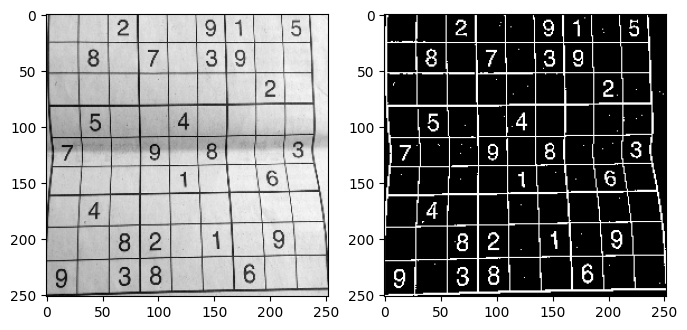

In [4]:
# Preprocess the selected image
SIZE = 28 * 9

cropped = img[y1:y2, x1:x2]
cropped = cv2.resize(cropped, (SIZE, SIZE))

gray = cv2.cvtColor(cropped, cv2.COLOR_BGR2GRAY)
thresh = cv2.adaptiveThreshold(gray, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY_INV, 11, 15)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1), plt.imshow(gray, 'gray')
plt.subplot(1, 2, 2), plt.imshow(thresh, 'gray')


(<Axes: >, <matplotlib.image.AxesImage at 0x162583750>)

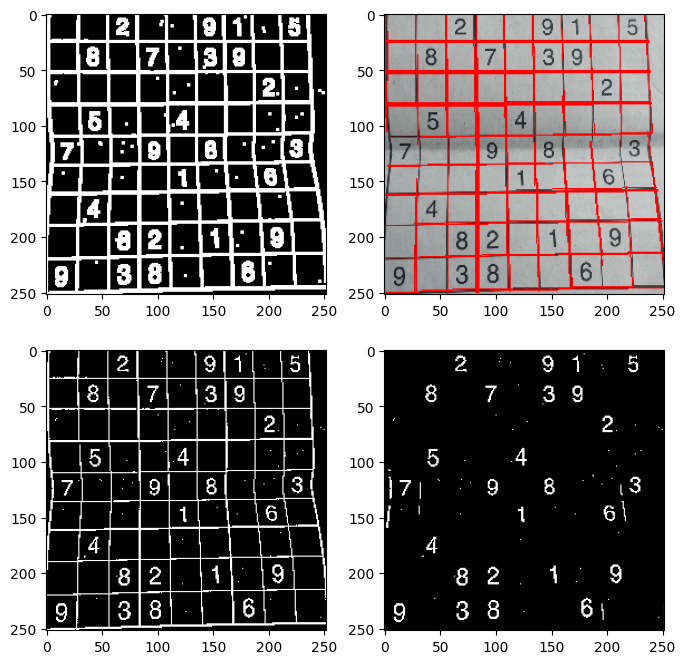

In [5]:
# Remove lines from image
detected_lines = cropped.copy()
removed = thresh.copy()

# Dilate image so the lines have more thickness hence easier to detect
dilated = cv2.dilate(thresh, np.ones((3, 3)))
lines = cv2.HoughLinesP(dilated, 1, np.pi / 180.0, 80, minLineLength=70, maxLineGap=4)
for line in lines:
    x1, y1, x2, y2 = line[0]

    # Draw line with red on original so we can see detected ones
    cv2.line(detected_lines, (x1, y1), (x2, y2), (255, 0, 0))

    # Hide line
    cv2.line(removed, (x1, y1), (x2, y2), 0, thickness=3)

plt.figure(figsize=(8, 8))
plt.subplot(2, 2, 1), plt.imshow(dilated, 'gray')
plt.subplot(2, 2, 2), plt.imshow(detected_lines)
plt.subplot(2, 2, 3), plt.imshow(thresh, 'gray')
plt.subplot(2, 2, 4), plt.imshow(removed, 'gray')
